# FCT Unesp
Aluno: Pétrus Antonio Bárbosa Pradella

##### Importando bibliotecas

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.mlemodel import MLEResults
import datetime

## Tratamento e Visualização dos dados

##### Terrotório Nacional Completo

In [21]:
#Ultimos 10 dias  de morte no BRASIL!
original_df = pd.read_csv("cases-brazil-states-08-05-2020.csv");
df_br = original_df.filter(['date', 'state', 'deaths']);
df_br = df_br.loc[df_br['state'] == "TOTAL"];

print("Ultimos 10 dias de Mortes no BRASIL")
print(df_br.tail(10));
print("\n\nGráfico da curva de crescimento das mortes")

fig = px.bar(df_br, x="date", y="deaths", color="deaths", barmode="group")
fig.show()

Ultimos 10 dias de Mortes no BRASIL
            date  state  deaths
1357  2020-04-29  TOTAL    5537
1385  2020-04-30  TOTAL    5980
1413  2020-05-01  TOTAL    6439
1441  2020-05-02  TOTAL    6810
1469  2020-05-03  TOTAL    7077
1497  2020-05-04  TOTAL    7381
1525  2020-05-05  TOTAL    7972
1553  2020-05-06  TOTAL    8597
1581  2020-05-07  TOTAL    9268
1609  2020-05-08  TOTAL    9960


Gráfico da curva de crescimento das mortes


Através desse gráfico podemos observar que o vírus em um período de 22 dias saltou de 1962 mortos para a incrível marca de 9960, ou seja, mais do que quintuplicou suas vítimas.

In [22]:
df = original_df.loc[original_df['date'] == "2020-05-08"];
df = df.loc[df['state'] != "TOTAL"];
df = df.loc[df['deaths'] > 100];
df = df.filter(['state', 'deaths']);
df = df.sort_values(by=['deaths'],ascending=False)

print("\n\nRelação de mortes por estados com mais de 100 mortes")
fig = px.bar(df, x="state", y="deaths", color="state", barmode="group", width=1000)
fig.show()



Relação de mortes por estados com mais de 100 mortes


O Estado de São Paulo concentra o maior número de óbitos ocorridos no Brasil, seguido pelo Rio de Janeiro e Ceara.

#### Estado de São Paulo

In [23]:
#Ultimos 10 dias  de morte no Estado DE SÃO PAULO!
df_sp = original_df.filter(['date', 'state', 'deaths']);
df_sp = df_sp.loc[df_sp['state'] == "SP"];

print("Ultimos 10 dias de Mortes no Estado de São Paulo")
print(df_sp.tail(10));

print("\n\nGráfico da curva de crescimento das mortes")

#foundNull = df_sp['deaths'].isnull().values.any(); #Nenhum valor nulo encontrado


fig = px.bar(df_sp, x="date", y="deaths", color="deaths", barmode="group")
fig.show()

Ultimos 10 dias de Mortes no Estado de São Paulo
            date state  deaths
1355  2020-04-29    SP    2247
1383  2020-04-30    SP    2375
1411  2020-05-01    SP    2511
1439  2020-05-02    SP    2586
1467  2020-05-03    SP    2627
1495  2020-05-04    SP    2654
1523  2020-05-05    SP    2851
1551  2020-05-06    SP    3045
1579  2020-05-07    SP    3206
1607  2020-05-08    SP    3416


Gráfico da curva de crescimento das mortes


O gráfico de mortes do Estado de São Paulo apresenta alguns picos de mortes em dias específicos, causando "saltos" no gráfico.

### Declarando classe auxiliadora para o método ARIMA

In [24]:
class AnalyticsARIMA():

    # ---------------------------------------------------------------------------
    #   Arima
    # ---------------------------------------------------------------------------

    modelFit:MLEResults = None;
    nomeDaColunaObjetivo = None;
    nomeDaColunaDeDatas = None;

    def arimaDefinirColunaObjetivo(self, nomeDaColunaObjetivo, nomeDaColunaDeDatas, conversaoAPartirDeString=False):
        self.nomeDaColunaObjetivo = nomeDaColunaObjetivo;
        self.nomeDaColunaDeDatas = nomeDaColunaDeDatas;

        if conversaoAPartirDeString is True:
            self.df[nomeDaColunaDeDatas] = pd.to_datetime(str(self.df[nomeDaColunaDeDatas]))
        else:
            self.df[nomeDaColunaDeDatas] = pd.to_datetime(self.df[nomeDaColunaDeDatas])

        self.df = self.df.groupby(nomeDaColunaDeDatas)[nomeDaColunaObjetivo].sum().reset_index()
        self.df = self.df.set_index(nomeDaColunaDeDatas)

    #Atenção, o dataFrame precisa estar AGRUPADO e ORDENADO
    def plotarDecomposicao(self, dataFrame=None, theModel='addtive', theFigsize = None, theFreq = None):
        from pylab import rcParams;
        import statsmodels.api as sm;
        rcParams['figure.figsize'] = 18, 8;

        if dataFrame is None:
            dataFrame = self.df;

        # Dois tipos de modelos possíves, Aditivo e Multiplicativo
        if theFreq is not None:
            decomposicao = sm.tsa.seasonal_decompose(dataFrame, model=theModel, freq=theFreq);
        else:
            decomposicao = sm.tsa.seasonal_decompose(dataFrame, model=theModel);
        if theFigsize is not None:
            plt.figure(figsize=theFigsize)
        decomposicao.plot();

    def aplicarARIMA(self, verbose = False):

        if verbose:
            print('# ===============================================================');
            print('# Preparando quantidade de treino.');
            print('# ===============================================================');

        import itertools;
        p = sazonalidade = range(0, 2);  # Arima P == auto-regressive part of the model
        d = tendencia = range(0, 2);  # Arima D == integrated part of the model
        q = ruido = range(0, 2);  # Arima Q == moving average part of the model

        # itertools.product basicamente relaciona todas as variáveis com todas as varíaveis... como já diz, PRODUCT
        pdq = list(itertools.product(sazonalidade, tendencia, ruido));

        # Criando agora as variações de calculos para o arima usar.
        # (Similar ao 'grid search' de machine learning)
        non_seasonal_pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))];

        if verbose == True:
            print(non_seasonal_pdq);

        if verbose:
            print('# ===============================================================');
            print('# Escolhendo a melhor combinação de parametros arima.');
            print('# ===============================================================');

        import warnings;
        warnings.filterwarnings("ignore")  # Negócio chato pacas...

        menorCombinacao = None;
        menorCombinacaoValor = 99999999999999999;  # Mesma coisa que Integer.MAX_VALUE

        from statsmodels.tsa.arima_model import ARIMA

        for parametro in pdq:
            try:
                model = ARIMA(self.df, order=parametro)
                resultado = model.fit(disp=0)#disp == 0 Oculta log indesejado que trava o programa....
                if resultado.aic < menorCombinacaoValor:
                    menorCombinacao = [parametro,[0],[0]];
                    menorCombinacaoValor = resultado.aic;
                if verbose == True:
                    print('ARIMA{} - AIC:{}'.format(parametro, resultado.aic))
            except:
                # Algumas combinações são NaN (Não são possíveis! por isso tem esse TryCath)
                continue

        if verbose == True:
            print('\n\n')
            print('O menor valor encontrado para o AIC é: {}'.format(menorCombinacaoValor))
            print('Utilizando a combinação: ARIMA{}x{}x{}'.format(menorCombinacao[0], menorCombinacao[1], menorCombinacao[2]))

        theOrder = menorCombinacao[0];

        if verbose:
            print('# ===============================================================');
            print('# Ajustando Modelo.');
            print('# ===============================================================');

        from statsmodels.tsa.arima_model import ARIMA
        mod = ARIMA(self.df, theOrder)

        self.modelFit = mod.fit(disp=0)#disp == 0 Oculta log indesejado que trava o programa....
        print('\n\n');
        print(self.modelFit.summary().tables[1])
        
    def ARIMAPrediction(self, forecastStartingDate = None ,datasetStartDate = None, theFigsize = (14, 7)):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        if forecastStartingDate == None:
            forecastStartingDate = self.df.index[0];

        # Predição propriamente dita
        pred = self.modelFit.plot_predict(start=pd.to_datetime(forecastStartingDate), dynamic=False)
        pred_ci = pred.conf_int()

        ax = self.df[datasetStartDate:].plot(label='Observado')
        pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=theFigsize)


        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel(self.nomeDaColunaDeDatas)
        ax.set_ylabel(self.nomeDaColunaObjetivo)
        plt.legend()
        plt.show()
        
    def ARIMAForecast(self, steps, datasetStartDate = None, theFigsize = (14, 7), verbose = False):

        if datasetStartDate == None:
            datasetStartDate = self.df.index[0];

        pred_uc = self.modelFit.forecast(steps=steps)[0]

        if verbose is True:
            print(pred_uc.predicted_mean)

        pred_ci = pred_uc.conf_int()

        ax = self.df[datasetStartDate:].plot(label='Observado')
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=theFigsize)

        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.2)

        ax.set_xlabel(self.nomeDaColunaDeDatas)
        ax.set_ylabel(self.nomeDaColunaObjetivo)
        plt.legend()
        plt.show()

def correlacao(df):
    plot_acf(df,lags=50,title="Autocorrelação")

## Aplicando ARIMA (Território Nacional)


In [25]:
analytics_br = AnalyticsARIMA();
analytics_br.df = df_br;
analytics_br.arimaDefinirColunaObjetivo(nomeDaColunaObjetivo='deaths', nomeDaColunaDeDatas='date')
analytics_br.aplicarARIMA(verbose=True);
print("Aplicando ARIMA para os dados NACIONAIS")

# ===============================================================
# Preparando quantidade de treino.
# ===============================================================
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
# ===============================================================
# Escolhendo a melhor combinação de parametros arima.
# ===============================================================
ARIMA(0, 0, 0) - AIC:1379.649277521487
ARIMA(0, 0, 1) - AIC:1288.5997234046315
ARIMA(0, 1, 0) - AIC:971.5351992797408
ARIMA(0, 1, 1) - AIC:899.9577322360333
ARIMA(1, 0, 0) - AIC:1025.6936498659932
ARIMA(1, 1, 0) - AIC:810.7544176255361



O menor valor encontrado para o AIC é: 810.7544176255361
Utilizando a combinação: ARIMA(1, 1, 0)x[0]x[0]
# ===============================================================
# Ajustando Modelo.
# ===============================================================



                     coef    std err          z      P>|z| 

O algorítimo realiza a aplicação do modelo ARIMA com diferentes pesos para as variáveis p,d,q. Dentre os resultados obtidos, aquele que possui o menor AIC (Akaike Information Critera) é mantido como parâmetro final.

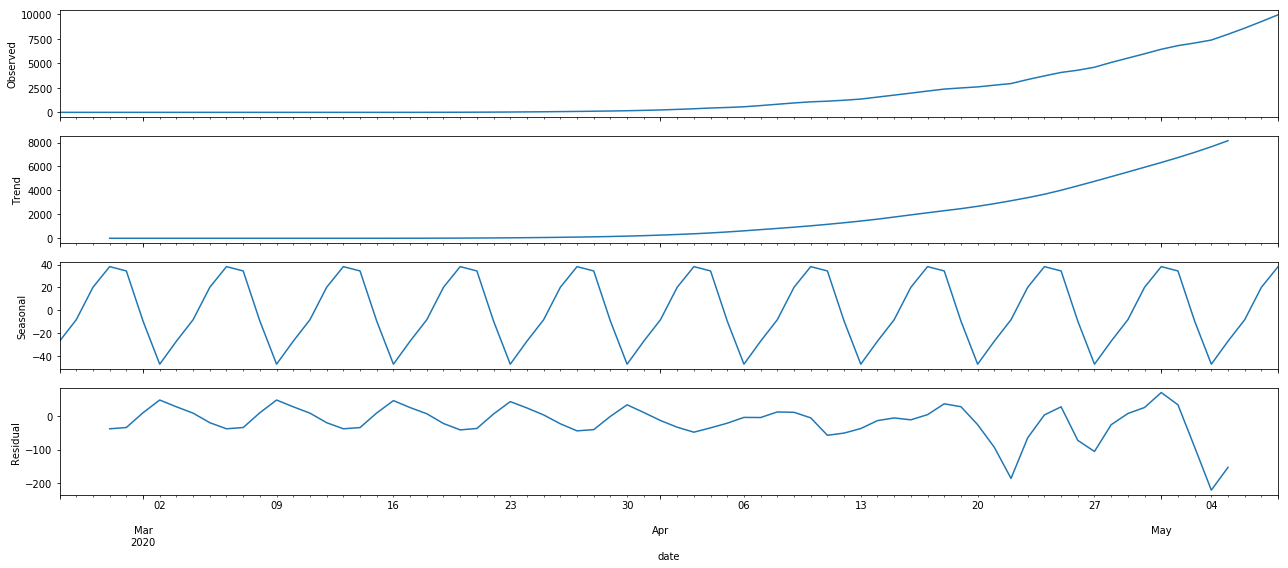

In [26]:
analytics_br.plotarDecomposicao()

Ao observar as tendencias, vemos que a curva tende a subir.

Mesmo que o algorítimo identifique uma sazonalidade aproximada, o tempo decorrido dês de o inicio da pandemia é muito curto para que esses valores tenham um peso relevante.

Ao observar o resíduo do modelo, podemos observar que os dados inicias da óbitos seguiam um padrão aproximado, contudo, a partir de abril os dados passaram a crescer de forma mais heterogênea.

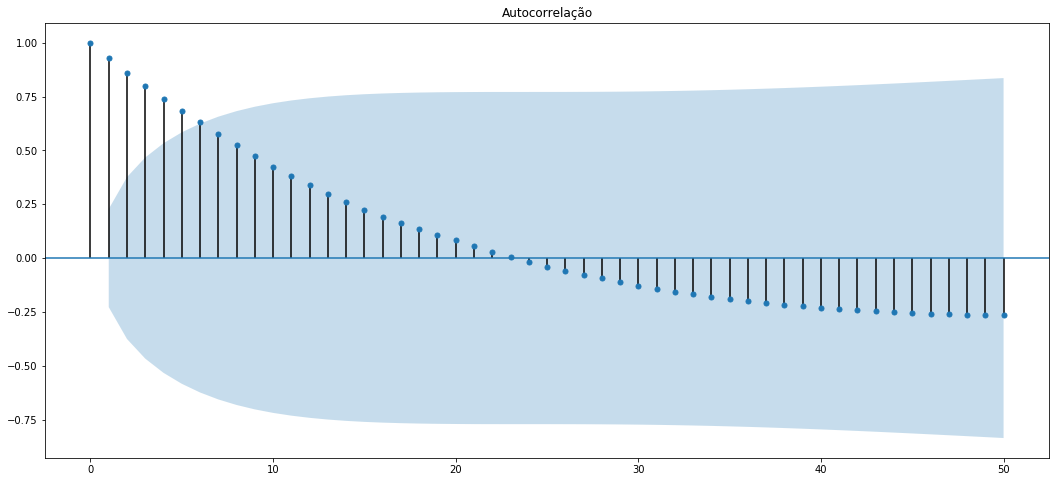

In [27]:
correlacao(analytics_br.df);


É possível observar por meio do primeiro gráfico que de fato existe uma Autocorrelação entre o crescimento dos óbitos por dia (embora isso seja evidente, afinal, é uma somatório).

Em vista que se trata de uma serie aparentemente estacionaria e de crescimento homogêneo, de fato é possível obter resultados promissores com o algorítimo ARIMA.

## Aplicando ARIMA (Estado de São Paulo)

In [28]:
analytics_sp = AnalyticsARIMA();
analytics_sp.df = df_sp;
analytics_sp.arimaDefinirColunaObjetivo(nomeDaColunaObjetivo='deaths', nomeDaColunaDeDatas='date')
analytics_sp.aplicarARIMA(verbose=True);
print("Aplicando ARIMA para os dados NACIONAIS")


# ===============================================================
# Preparando quantidade de treino.
# ===============================================================
[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
# ===============================================================
# Escolhendo a melhor combinação de parametros arima.
# ===============================================================
ARIMA(0, 0, 0) - AIC:1230.5784489312246
ARIMA(0, 0, 1) - AIC:1138.741180158108
ARIMA(0, 1, 0) - AIC:816.2069015241308
ARIMA(0, 1, 1) - AIC:779.0095109464618
ARIMA(1, 0, 0) - AIC:883.7782223439666
ARIMA(1, 1, 0) - AIC:749.2218924290505
ARIMA(1, 1, 1) - AIC:751.0990302788887



O menor valor encontrado para o AIC é: 749.2218924290505
Utilizando a combinação: ARIMA(1, 1, 0)x[0]x[0]
# ===============================================================
# Ajustando Modelo.
# ===============================================================



                     

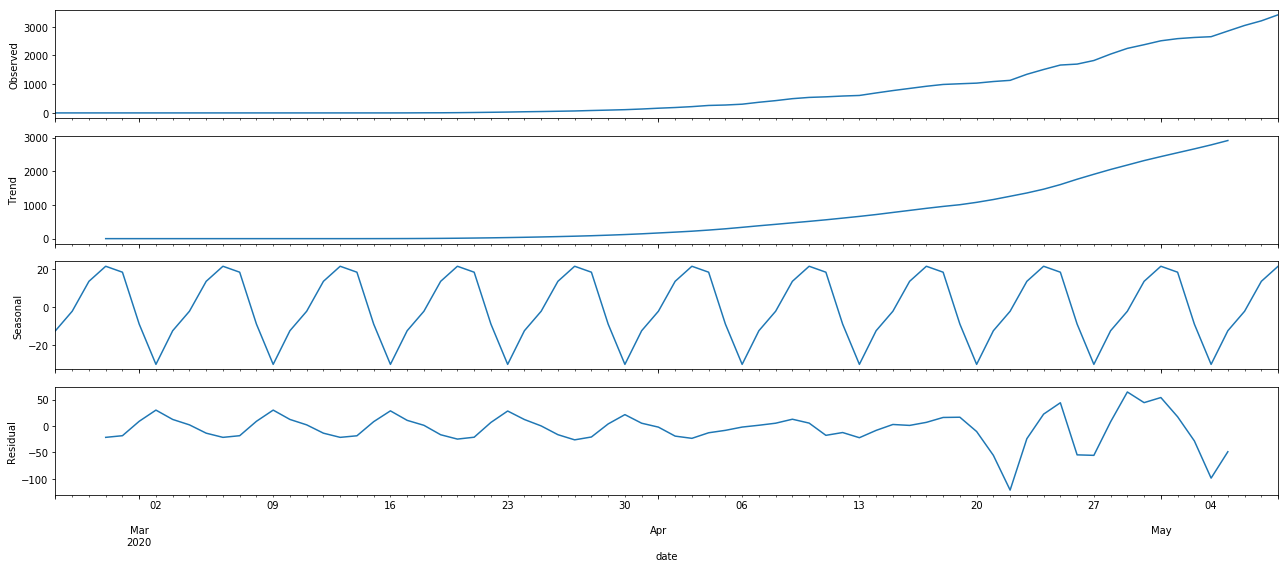

In [29]:
analytics_sp.plotarDecomposicao()

É possivel observar que o ruido tambem está bem presente nos dados análisados do Estado de São Paulo.


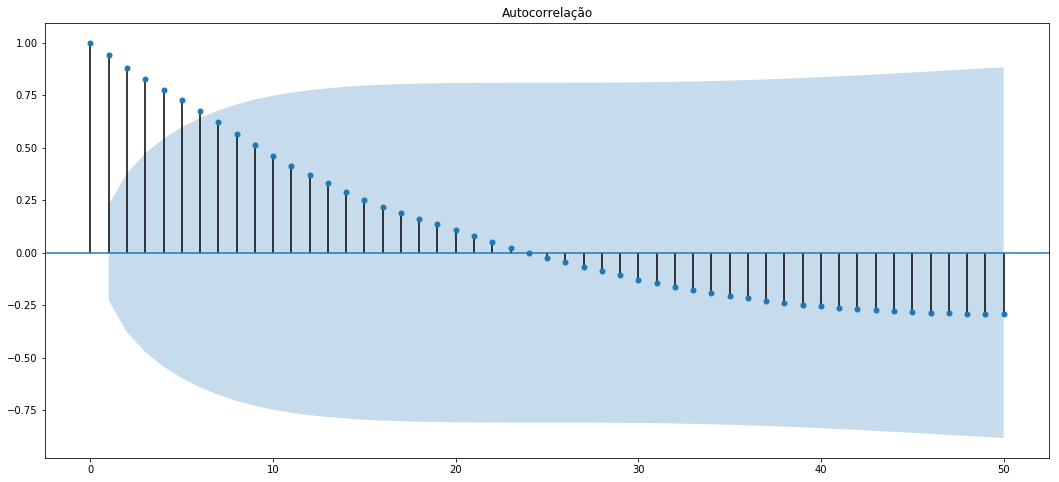

In [30]:
correlacao(analytics_sp.df);

## Forecast (Previsão)

É importante salientar que o ARIMA não é um modelo matemático criado especificamente para a análise de propagação de doenças, inclusive existem diversos outros modelos matemáticos específicos para isso.

Alem disso, sem saber o "final" da curva, não é possível estipular até quando os óbitos irão subir, por essa razão, o forecast do ARIMA deve ser olhado como uma previsão de curto prazo.

### Forecast BRASIL

In [31]:
#analytics_br.ARIMAPrediction("05-05-2020")

In [32]:
#analytics_br.ARIMAForecast(steps=10)

### Forecast São Paulo

In [33]:

pred = analytics_br.modelFit.forecast(steps=12)

In [34]:
import pandas as pd
from datetime import timedelta
ultimo_dia = pd.to_datetime(str(analytics_br.df.tail(1).index[0]));
df_pred = pd.DataFrame(columns=['date', 'deaths']);
for previsao in pred[0]:
    ultimo_dia = ultimo_dia + timedelta(days=1)
    new_row = {'date': ultimo_dia, 'deaths' : previsao};
    df_pred = df_pred.append(new_row, ignore_index=True);
df_pred

,date,deaths
0,2020-05-09,10641.974558
1,2020-05-10,11314.151053
2,2020-05-11,11976.751704
3,2020-05-12,12629.993693
4,2020-05-13,13274.089274
5,2020-05-14,13909.245889
6,2020-05-15,14535.666274
7,2020-05-16,15153.548566
8,2020-05-17,15763.086412
9,2020-05-18,16364.469062


In [35]:
temp = AnalyticsARIMA();
temp.df = df_pred;

In [36]:
temp.df

,date,deaths
0,2020-05-09,10641.974558
1,2020-05-10,11314.151053
2,2020-05-11,11976.751704
3,2020-05-12,12629.993693
4,2020-05-13,13274.089274
5,2020-05-14,13909.245889
6,2020-05-15,14535.666274
7,2020-05-16,15153.548566
8,2020-05-17,15763.086412
9,2020-05-18,16364.469062


In [37]:
temp.arimaDefinirColunaObjetivo('date','deaths');
df_pred = temp.df;


TypeError: DatetimeIndex cannot perform the operation sum

In [ ]:
#Plotting results
f,ax=plt.subplots()
plt.plot(df_pred,c='green', label= 'Predição')
#plt.plot(analytics_br.df,c='green', label= 'Predição')
plt.legend()
    #Printing the error metrics